# Урок 4. CNN
## Домашнее задание
1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

Загрузим CIFAR100

In [4]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


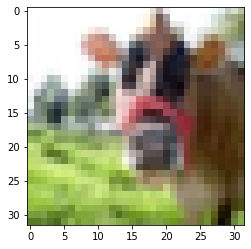

In [5]:
plt.imshow(dataset[0][0])
plt.show()

In [6]:
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])


def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

In [7]:
train_dataset, test_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
test_dataset = MyOwnCifar(test_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=1024,
                          shuffle=True,
                          num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Создадим свою архитектуру сети. В отличии от сети для CIFAR10, представленной на вебинаре, эта сеть имеет больше сверточных слоев на каждом слое сети, и, соответственно, полносвязные слои также шире. Сделано это из тех соображений, что классов больше, значит полносвязные слои должны быть шире, значит и в сверточных слоях должно быть больше сверток.

In [15]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 64, 3)
        self.bn_two = torch.nn.BatchNorm2d(64) 
        self.conv_two = torch.nn.Conv2d(64, 128, 3)
        self.bn_three = torch.nn.BatchNorm2d(128)
        self.conv_three = torch.nn.Conv2d(128, 256, 3)
        self.bn_four = torch.nn.BatchNorm2d(256)
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.out = torch.nn.Linear(256, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=100, bias=True)
)


In [16]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [17]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 30, 30]           1,792
       BatchNorm2d-3           [-1, 64, 15, 15]             128
            Conv2d-4          [-1, 128, 13, 13]          73,856
       BatchNorm2d-5            [-1, 128, 6, 6]             256
            Conv2d-6            [-1, 256, 4, 4]         295,168
       BatchNorm2d-7            [-1, 256, 2, 2]             512
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 256]         131,328
           Linear-12                  [-1, 100]          25,700
Total params: 1,053,546
Trainable params: 1,053,546
Non-trainable params: 0
---------------------------

In [18]:
def learn_net(net, criterion, optimizer, num_epochs):
  train_acc = []
  test_acc = []
  for epoch in range(num_epochs):
      running_loss = 0.0
      running_items = 0.0
      running_loss_test = 0.0
      running_items_test = 0.0
      running_right = 0.0
      running_right_test = 0.0

      net.train()
      for i, data in enumerate(train_loader):
          inputs, labels = data[0].to(device), data[1].to(device)
          # Обнуляем градиент
          optimizer.zero_grad()
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = criterion(outputs, labels)
          # Делаем шаг назад по лоссу
          loss.backward()
          # Делаем шаг нашего оптимайзера
          optimizer.step()

          # выводим статистику о процессе обучения
          running_loss += loss.item()
          running_items += len(labels)
          running_right += (labels == torch.max(outputs, 1)[1]).sum()

      running_right = running_right.item() 
      print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
            f'Loss_train: {running_loss / (i + 1):.3f}. ' \
            f'Acc: {running_right / running_items:.3f}.', end=' ')
      acc = running_right / running_items
      train_acc.append(acc)
      # print(type(acc), acc, train_acc)
      running_loss, running_items, running_right = 0.0, 0.0, 0.0

      net.eval()
      for i, data in enumerate(test_loader):
          inputs, labels = data[0].to(device), data[1].to(device)
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = criterion(outputs, labels)

          running_loss_test += loss.item()
          running_items_test += len(labels)
          running_right_test += (labels == torch.max(outputs, 1)[1]).sum()

      running_right_test = running_right_test.item()
      print(f'Loss_test: {running_loss_test / (i + 1):.3f}. ' \
            f'Acc_test: {running_right_test / running_items_test:.3f}')
      test_acc.append(running_right_test / running_items_test)
      running_loss_test, running_items_test, running_right_test = 0.0, 0.0, 0.0

  print('Training is finished!')

  return train_acc, test_acc

Обучим нашу сеть:

In [19]:
train_acc, test_acc = learn_net(net, criterion, optimizer, 100)

Epoch [1/100]. Loss_train: 4.305. Acc: 0.046. Loss_test: 4.091. Acc_test: 0.062
Epoch [2/100]. Loss_train: 4.034. Acc: 0.075. Loss_test: 3.946. Acc_test: 0.094
Epoch [3/100]. Loss_train: 3.865. Acc: 0.101. Loss_test: 3.874. Acc_test: 0.097
Epoch [4/100]. Loss_train: 3.756. Acc: 0.118. Loss_test: 3.746. Acc_test: 0.129
Epoch [5/100]. Loss_train: 3.649. Acc: 0.137. Loss_test: 3.806. Acc_test: 0.123
Epoch [6/100]. Loss_train: 3.539. Acc: 0.153. Loss_test: 3.913. Acc_test: 0.124
Epoch [7/100]. Loss_train: 3.433. Acc: 0.173. Loss_test: 3.898. Acc_test: 0.141
Epoch [8/100]. Loss_train: 3.349. Acc: 0.188. Loss_test: 3.480. Acc_test: 0.171
Epoch [9/100]. Loss_train: 3.270. Acc: 0.199. Loss_test: 3.664. Acc_test: 0.164
Epoch [10/100]. Loss_train: 3.203. Acc: 0.215. Loss_test: 3.487. Acc_test: 0.176
Epoch [11/100]. Loss_train: 3.136. Acc: 0.227. Loss_test: 4.045. Acc_test: 0.157
Epoch [12/100]. Loss_train: 3.095. Acc: 0.232. Loss_test: 3.683. Acc_test: 0.186
Epoch [13/100]. Loss_train: 3.041. Ac

Отрисуем метрику Accuracy для трейна и теста:

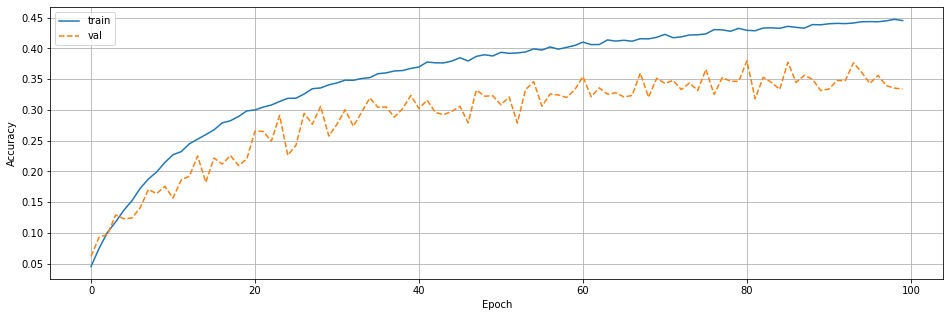

In [20]:
plt.figure(figsize = (16,5))
plt.plot(train_acc,'-',label = f'train')
plt.plot(test_acc,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

Как видно сеть довольно сильно переобучается. На трейне метрика растет довольно плавно и еще не вышла на пик, а на тесте, похоже, график уже насытился. Таким образом максимальная метрика на тесте - 0.35 +- скачки. Но надо сказать, что Accuracy 0.35 для 100 объектов - это довольно неплохо.

Загрузим претренированную модель:

In [33]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Запретим претренированным слоям обучаться:

In [35]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

Переназначим последний плотный слой на классификацию 100 объектов:

In [36]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [37]:
resnet50 = resnet50.to(device)

In [38]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, test_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
test_dataset = MyOwnCifar(test_dataset, test_transforms)

In [39]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=2)

In [40]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

Обучим плотный слой претренированной сети. Из-за маленького батча обучение шло час, с большим батчем заканчивалась оперативка.

In [41]:
train_acc, test_acc = learn_net(resnet50, criterion, optimizer, 20)

Epoch [1/20]. Loss_train: 2.442. Acc: 0.412. Loss_test: 1.771. Acc_test: 0.520
Epoch [2/20]. Loss_train: 1.716. Acc: 0.537. Loss_test: 1.635. Acc_test: 0.549
Epoch [3/20]. Loss_train: 1.608. Acc: 0.561. Loss_test: 1.535. Acc_test: 0.574
Epoch [4/20]. Loss_train: 1.529. Acc: 0.578. Loss_test: 1.524. Acc_test: 0.569
Epoch [5/20]. Loss_train: 1.483. Acc: 0.590. Loss_test: 1.530. Acc_test: 0.572
Epoch [6/20]. Loss_train: 1.459. Acc: 0.592. Loss_test: 1.583. Acc_test: 0.567
Epoch [7/20]. Loss_train: 1.433. Acc: 0.602. Loss_test: 1.525. Acc_test: 0.581
Epoch [8/20]. Loss_train: 1.403. Acc: 0.608. Loss_test: 1.539. Acc_test: 0.576
Epoch [9/20]. Loss_train: 1.385. Acc: 0.610. Loss_test: 1.490. Acc_test: 0.588
Epoch [10/20]. Loss_train: 1.365. Acc: 0.617. Loss_test: 1.495. Acc_test: 0.588
Epoch [11/20]. Loss_train: 1.357. Acc: 0.618. Loss_test: 1.476. Acc_test: 0.596
Epoch [12/20]. Loss_train: 1.326. Acc: 0.626. Loss_test: 1.482. Acc_test: 0.592
Epoch [13/20]. Loss_train: 1.320. Acc: 0.626. Los

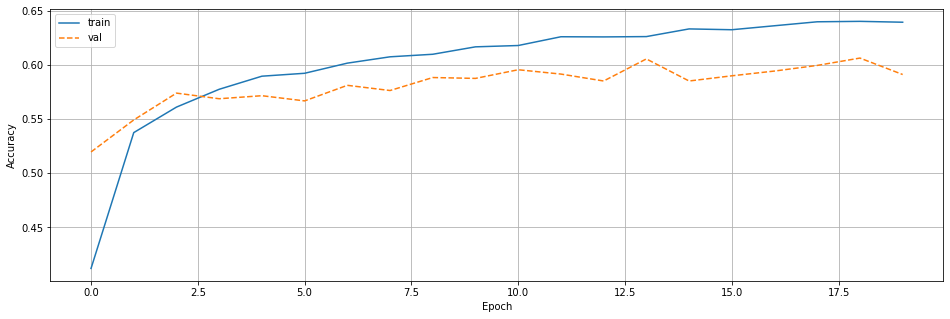

In [42]:
plt.figure(figsize = (16,5))
plt.plot(train_acc,'-',label = f'train')
plt.plot(test_acc,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

Обучение предобученной сети, конечно, поражает. После первой же эпохи 0.52 на тесте. Обучение и на трейне и на тесте прошло довольно плавно, после 20 эпох очень похоже, что сеть достигла своего максимума по метрике. Итак, на трейне Accuracy 0.64, на тесте 0.60